In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from scipy.ndimage import rotate
import time

In [64]:
train = pd.read_csv("thedataset/version2.csv")
train
# Get the name of the first column
first_column_name = train.columns[0]
classes = []
# Select the first column
first_column = train[first_column_name]

# Get the unique values
unique_values = first_column.unique()
classes.append(unique_values)
# Print the unique values
print(unique_values)

[27 28 29 31 32 30 67 68 70 71]


In [65]:
mapping = {27: "ç", 28: "ğ", 67: "Ğ", 29: "ı", 68: "İ", 30: "ş", 31: "ö", 70: "Ö", 32: "ü", 71: "Ü" }

> This dataset has been provided by 
---
"G. Ediboğlu Bartos, Y. Hoscan, A. Kauer, and É. Hajnal, “A Multilingual Handwritten Character Dataset: T-H-E Dataset,” Acta Polytechnica Hungarica, 2020.(under acceptance)"
> The classes this dataset include ç-27 Ç-66 ğ-28 Ğ-67 ı-29 İ-68 ş-30 Ş-69 ö-31 Ö-70 ü-32 Ü-71 but the classes 66 and 69 which are capital Ç and Ş missing.

> I will be using another dataset to close the gaps and widen the training set.

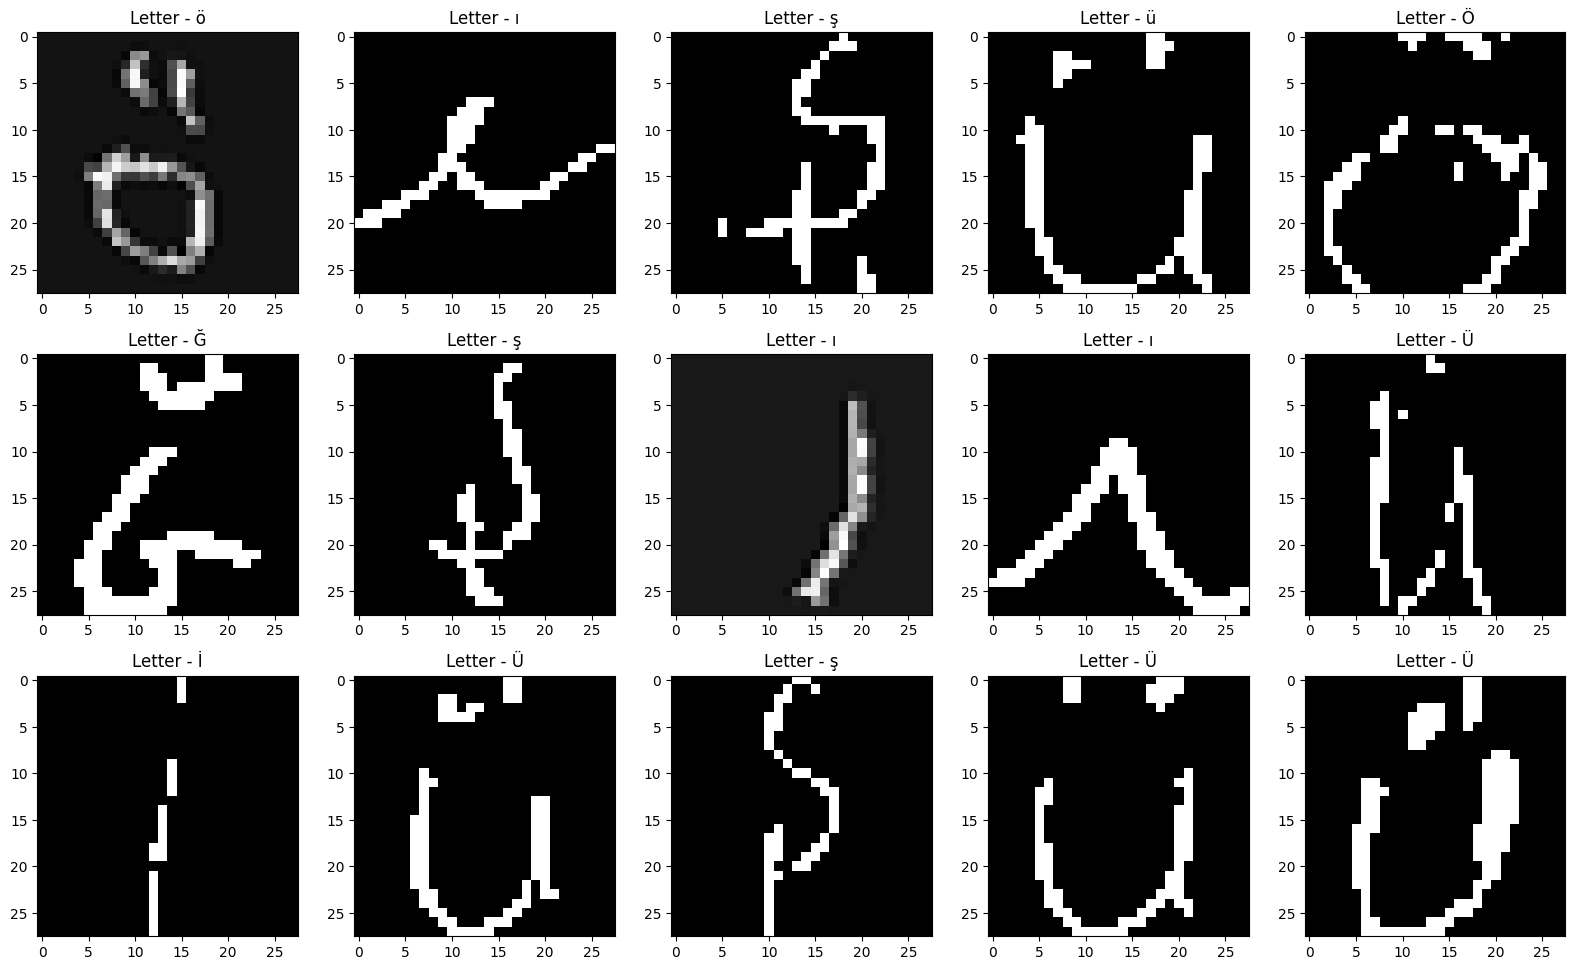

In [66]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        random_class = random.choice(list(mapping.keys()))
        filtered_train = train[train[first_column_name] == random_class]
        random_row = filtered_train.sample()    
        pixels = np.array(random_row.iloc[0])
        pixels = pixels[1:]
        image = pixels.reshape(28, 28)
        image = image.T
        plt.subplot(5, 5,idx+1)
        plt.imshow(image, cmap = mono)
        plt.title(f"Letter - {mapping[random_class]}")
        
    plt.tight_layout()
    
Show_example_digits()

In [67]:
# Setting a location for the data.
data = "extended_emnist"

# Setting up training and testing datas.
train_data = datasets.EMNIST(
    root=data,
    split="byclass",
    train= True,
    transform=ToTensor(),
    download=False,
    target_transform=None
)

test_data = datasets.EMNIST(
    root=data,
    split="byclass",
    train=False,
    transform=ToTensor(),
    download=False
)

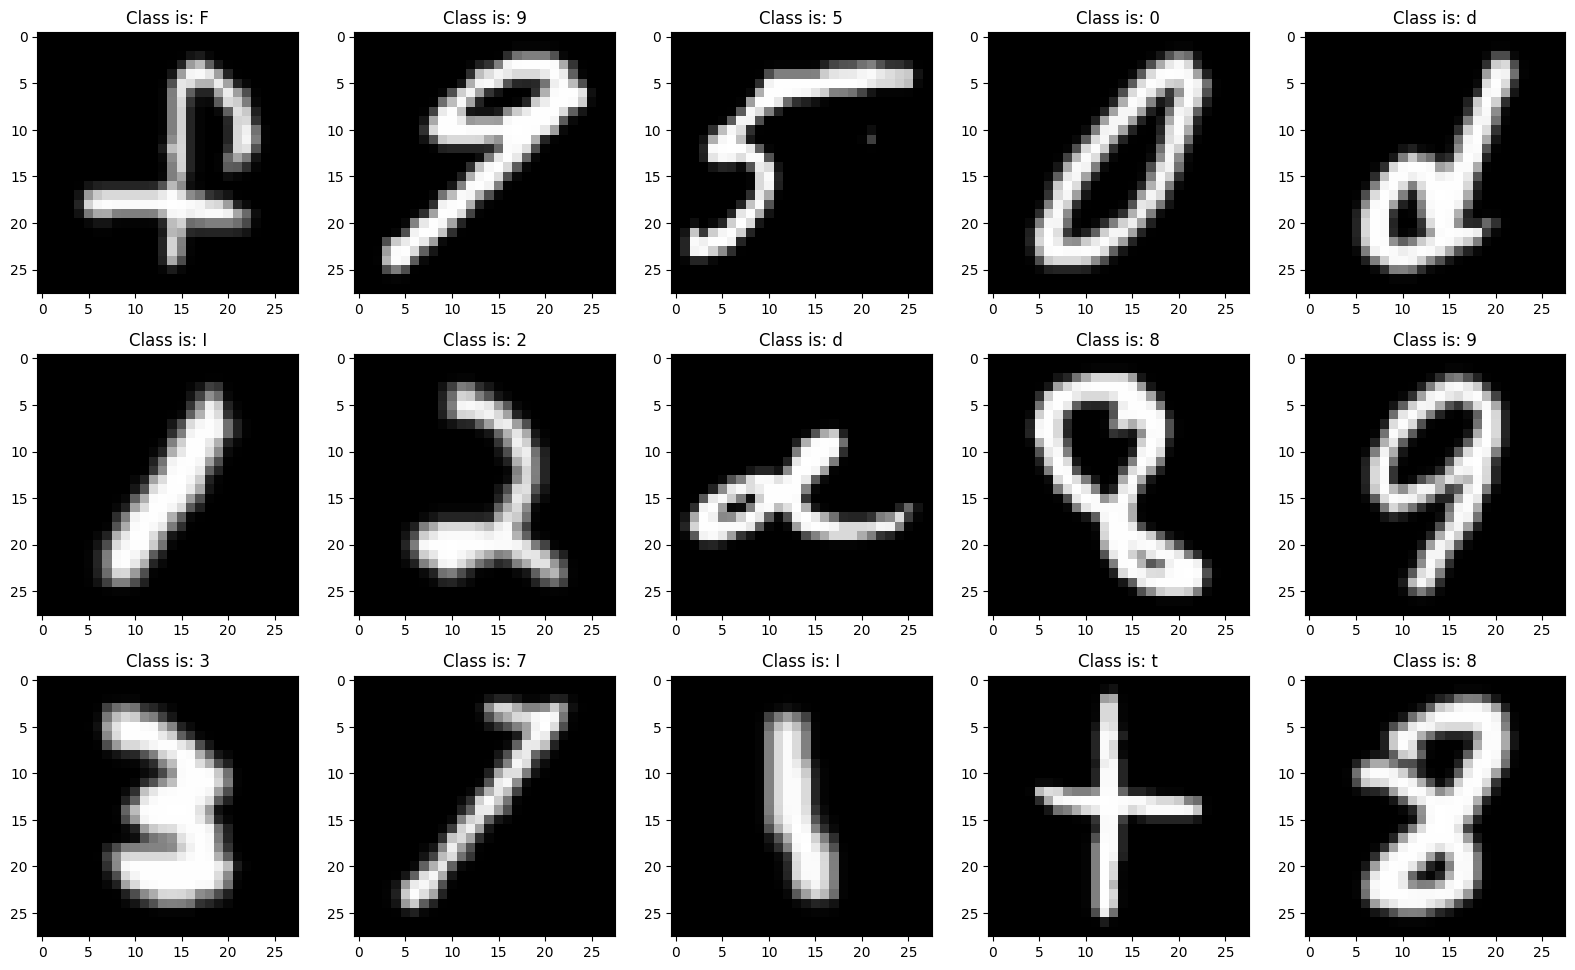

In [68]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        number = random.randint(0, len(train_data))
        image, label = train_data[number]
        angle = -90
        rotated_image = rotate(image.squeeze(), angle)
        flipped_image = np.fliplr(rotated_image.squeeze())
        plt.subplot(5, 5,idx+1)
        plt.imshow(flipped_image.squeeze(),cmap='gray')
        plt.title(f"Class is: {train_data.classes[label]}")
    
    plt.tight_layout()

Show_example_digits()

Class 0 (0): 34585
Class 1 (1): 38374
Class 2 (2): 34203
Class 3 (3): 35143
Class 4 (4): 33535
Class 5 (5): 31416
Class 6 (6): 34232
Class 7 (7): 35754
Class 8 (8): 33946
Class 9 (9): 33847
Class 10 (A): 6407
Class 11 (B): 3878
Class 12 (C): 10094
Class 13 (D): 4562
Class 14 (E): 4934
Class 15 (F): 9182
Class 16 (G): 2517
Class 17 (H): 3152
Class 18 (I): 11946
Class 19 (J): 3762
Class 20 (K): 2468
Class 21 (L): 5076
Class 22 (M): 9002
Class 23 (N): 8237
Class 24 (O): 24983
Class 25 (P): 8347
Class 26 (Q): 2605
Class 27 (R): 5073
Class 28 (S): 20764
Class 29 (T): 9820
Class 30 (U): 12602
Class 31 (V): 4637
Class 32 (W): 4695
Class 33 (X): 2771
Class 34 (Y): 4743
Class 35 (Z): 2701
Class 36 (a): 10033
Class 37 (b): 5159
Class 38 (c): 2854
Class 39 (d): 10177
Class 40 (e): 24631
Class 41 (f): 2561
Class 42 (g): 3687
Class 43 (h): 8738
Class 44 (i): 2725
Class 45 (j): 1896
Class 46 (k): 2491
Class 47 (l): 15318
Class 48 (m): 2645
Class 49 (n): 11418
Class 50 (o): 2749
Class 51 (p): 2448
Cl

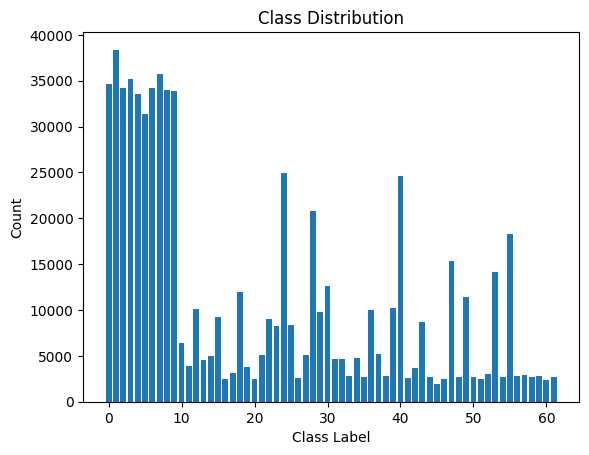

In [69]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of instances per class
class_counts = Counter([train_data[i][1] for i in range(len(train_data))])

# Print the class counts
for class_label, count in sorted(class_counts.items()):
    print(f"Class {class_label} ({train_data.classes[class_label]}): {count}")

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [70]:
train_data.classes[0]

'0'

In [71]:
print(torch.cuda.device_count())
torch.cuda.get_device_name()

1


'NVIDIA GeForce RTX 2060'

In [72]:
# CPU
start_time = time.time()
a = torch.ones(4,4)
for _ in range(1000000):
    a += a
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

# GPU
start_time = time.time()
b = torch.ones(4,4).cuda()
for _ in range(1000000):
    b += b
elapsed_time = time.time() - start_time
print('GPU time = ',elapsed_time)

CPU time =  1.7860863208770752
GPU time =  18.131277799606323


The GPU’s strength comes from its ability to perform many operations in parallel, so it’s generally more efficient for complex operations or large data sizes1. However, in your case, the operation is quite simple (just addition), and the size of the tensor is small (only 4x4). This means there’s not much opportunity for parallelization, which is why the GPU might not be faster than the CPU1.

In addition, there’s some overhead when transferring data between the CPU and the GPU. If the computation time is small compared to this overhead, then the GPU can end up being slower than the CPU1.

Another factor could be the data type. GPUs are mostly optimized for operations on 32-bit floating numbers. If you’re using a different data type (like double), the GPU might be slower2.

Finally, the first CUDA call in a program is slow because it involves initializing the CUDA context1. If your program only makes a few CUDA calls, this initialization overhead can make the GPU slower than the CPU1.

In [73]:
filtered_data = [instance for instance in train_data if instance[1] >= 10]

In [93]:
len(train_data),len(filtered_data), len(train)

(697932, 352897, 19999)

>We've successfully edited our data to remove the digits so only our letter classes be implemented.